<a href="https://colab.research.google.com/github/paulrobustelli/CHEM101.6/blob/main/Butane_OpenMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 

---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
3.    py3Dmol (https://pypi.org/project/py3Dmol/)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer

conda install -c conda-forge ambertools

conda install -c ambermd pytraj 

conda install -c conda-forge biopandas

conda install -c conda-forge mdanalysis

conda install -c conda-forge py3dmol

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj

conda install -c conda-forge nglview



In [2]:
import numpy as np
# import py3Dmol
import platform
import scipy.cluster.hierarchy

from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#load dependencies

import os
import sys
from simtk import openmm as mm

# import openmm as mm
# from openmm import *
# from openmm.app import *
# from openmm.unit import *
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit

import numpy as np
# import py3Dmol

#import pytraj as pt
import platform
import scipy.cluster.hierarchy

from scipy.spatial.distance import squareform
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import seaborn as sns
from statistics import mean, stdev
#from pytraj import matrix
from matplotlib import colors
from IPython.display import set_matplotlib_formats

import MDAnalysis as mda
import mdtraj as md


In [4]:
from __future__ import print_function
from IPython.display import set_matplotlib_formats


In [5]:
from simtk import unit
from simtk.openmm import app

datadir='/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/'
workDir='/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/outdir/'
initial_pdb='/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/butane.pdb'
force_field='/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/butane.gaff2.xml'

if not os.path.exists(workDir):
    os.makedirs(workDir)
    
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/butane.pdb
/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/butane.gaff2.xml


In [6]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 15.811371105951306 kJ/mol
Potential energy after minimization is 7.72472989883596 kJ/mol


In [7]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,25.86487700637571,201.36208685580638
200,35.33570747831537,203.62074853192283
300,31.75258184526316,180.06976365227854
400,30.77784816454814,337.11469862915476
500,50.293451441109774,249.86819510489553
600,48.73638878610312,292.798515156816
700,48.3985461843281,337.5930736432716
800,41.536365363250376,314.82922236556374
900,48.7789248152829,313.86100348285953
1000,52.84289644714817,390.6863381007981
1100,49.3561581271566,382.4173111487683
1200,59.975605568754176,487.7592436877031
1300,52.79640935591016,426.5467484897866
1400,49.401877189274444,322.5678901321795
1500,35.90590797301584,311.02227001672907
1600,45.529714526208124,309.5917469527192
1700,47.961834077330394,280.1293733912164
1800,48.623226422356474,198.65654490533896
1900,51.56440010959485,329.82042225278644
2000,60.1242860755097,375.5924817404662
2100,36.2491810557363,309.05683055122904
2200,43.90902563208674,214.2241007361959
2300,43.38030761592792,

In [8]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(1000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,59.10651284338446,297.06503989636747,0
500000,999.9999999901769,57.02848211436795,303.96091911188694,1.74e+04
750000,1499.9999999783536,43.927850135652484,322.2652567939603,1.73e+04
1000000,1999.9999999665301,50.60493569014595,351.0237490370484,1.74e+04
Done!
Time required for simulation: 9.979580879211426 seconds


In [9]:
#print(workDir+'butane_sim.dcd')
#simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))
traj = md.load(workDir+'butane_sim.dcd', top=initial_pdb)
traj
#traj.superpose(ref)

<mdtraj.Trajectory with 10000 frames, 14 atoms, 1 residues, without unitcells at 0x7ff215d41910>

In [10]:
#jupyter-nbextension enable --py --user nglview
#jupyter-nbextension enable --py --user widgetsnbextension 

from ipywidgets import interact, fixed
import nglview as ngl
from nglview.player import TrajectoryPlayer
traj = md.load(workDir+'butane_sim.dcd', top=initial_pdb)
t = ngl.MDTrajTrajectory(traj)
w = ngl.NGLWidget(t)
w

NGLWidget(max_frame=9999)

In [11]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,LIG,0,
1,2,C2,C,1,LIG,0,
2,3,C3,C,1,LIG,0,
3,4,C4,C,1,LIG,0,
4,5,H11,H,1,LIG,0,
5,6,H12,H,1,LIG,0,
6,7,H13,H,1,LIG,0,
7,8,H21,H,1,LIG,0,
8,9,H22,H,1,LIG,0,
9,10,H31,H,1,LIG,0,


In [12]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x7ff215cd20d0>

In [13]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[0 1 2 3]
LIG1-C1
LIG1-C2
LIG1-C3
LIG1-C4


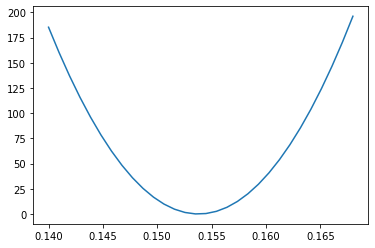

In [14]:
bond_lengths = np.linspace(0.140,0.168, 30)

def harmonic_bond_E(k,b,b0):
    return (k/2*(b-b0)**2)

bond_E = harmonic_bond_E(1945727.27,bond_lengths,0.15380)
bond_E

plt.plot(bond_lengths, bond_E)

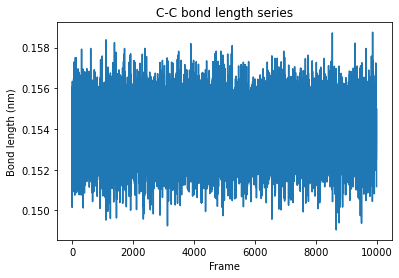

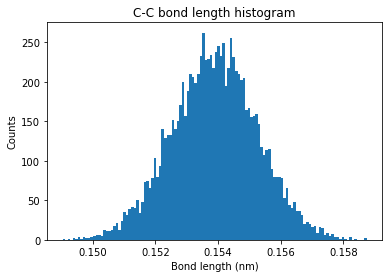

In [15]:
#Compute Some Distances and plot the time course - Bond 0-4
C1C2bond_indices = [0, 1] 
C1C2bond_length = md.compute_distances(traj, [C1C2bond_indices])

plt.plot(C1C2bond_length)
plt.title('C-C bond length series')
plt.xlabel('Frame')
plt.ylabel('Bond length (nm)')
plt.show()

plt.clf()

bondcounts, binedges, otherstuff = plt.hist(C1C2bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

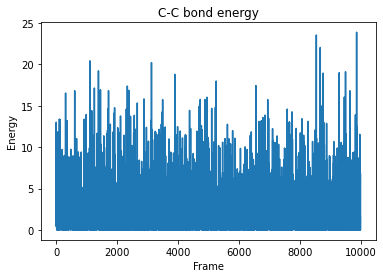

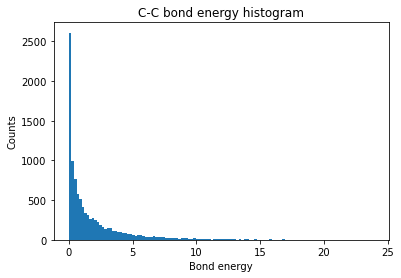

In [16]:
C1C2_bond = C1C2bond_length[:,0]
C1C2_E = harmonic_bond_E(1945727.27,C1C2_bond,0.15380)

plt.plot(C1C2_E)
plt.title('C-C bond energy')
plt.xlabel('Frame')
plt.ylabel('Energy')
plt.show()

plt.clf()

plt.hist(C1C2_E,bins = 120)
plt.title('C-C bond energy histogram')
plt.xlabel('Bond energy')
plt.ylabel('Counts')
plt.show()

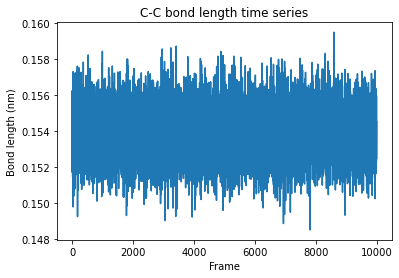

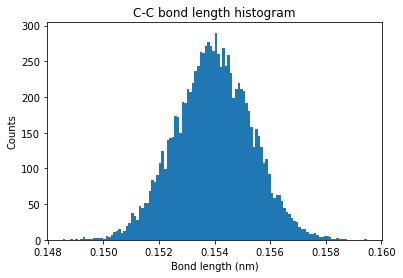

In [17]:
#Compute Some Distances and plot the time course - Bond 0-4

C2C3bond_indices = [1, 2] 
C2C3bond_length = md.compute_distances(traj, [C2C3bond_indices])

plt.plot(C2C3bond_length)
plt.title('C-C bond length time series')
plt.xlabel('Frame')
plt.ylabel('Bond length (nm)')
plt.show()

plt.clf()

bondcounts, binedges, otherstuff = plt.hist(C2C3bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

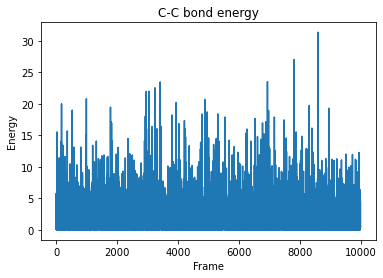

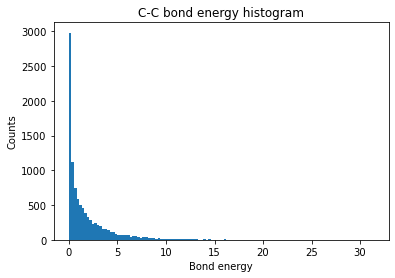

In [18]:
C2C3_bond = C2C3bond_length[:,0]
C2C3_E = harmonic_bond_E(1945727.27,C2C3_bond,0.15380)

plt.plot(C2C3_E)
plt.title('C-C bond energy')
plt.xlabel('Frame')
plt.ylabel('Energy')
plt.show()

plt.clf()

plt.hist(C2C3_E, bins=120)
plt.title('C-C bond energy histogram')
plt.xlabel('Bond energy')
plt.ylabel('Counts')
plt.show()

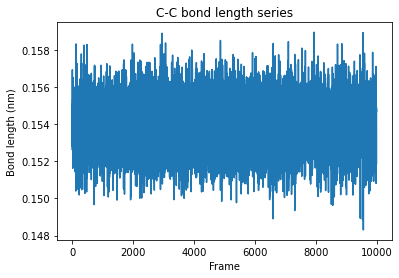

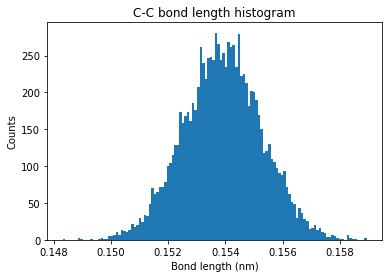

In [19]:
#Compute Some Distances and plot the time course - Bond 0-4
C3C4bond_indices = [2, 3] 
C3C4bond_length = md.compute_distances(traj, [C3C4bond_indices])

plt.plot(C3C4bond_length)
plt.title('C-C bond length series')
plt.xlabel('Frame')
plt.ylabel('Bond length (nm)')
plt.show()

plt.clf()

bondcounts, binedges, otherstuff = plt.hist(C3C4bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

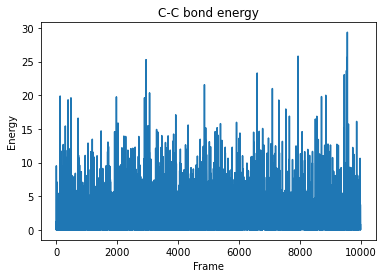

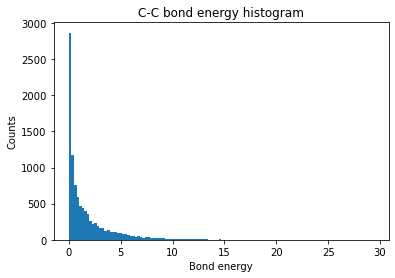

In [20]:
C3C4_bond = C3C4bond_length[:,0]
C3C4_E = harmonic_bond_E(1945727.27,C3C4_bond,0.15380)

plt.plot(C3C4_E)
plt.title('C-C bond energy')
plt.xlabel('Frame')
plt.ylabel('Energy')
plt.show()

plt.clf()

plt.hist(C3C4_E, bins=120)
plt.title('C-C bond energy histogram')
plt.xlabel('Bond energy')
plt.ylabel('Counts')
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

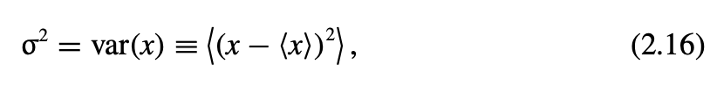

In [21]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######
def variance(data):
    ave = np.average(data)
    var = np.average((data-ave)**2)
    std = var**0.5
    return var, std

In [22]:
###SOLUTION###
var,std = variance(C1C2_bond)
print(var,std)

var,std = variance(C2C3_bond)
print(var,std)

var,std = variance(C3C4_bond)
print(var,std)

1.8506757e-06 0.0013603954367051789
1.8672623e-06 0.001366478068895123
1.8573717e-06 0.0013628542370981579


In [23]:
#Lets Check Our Answers with the Built In Numpy Libraries np.var and np.std
C1C2_average = np.average(C1C2_bond)
C1C2_var = np.var(C1C2_bond)
C1C2_std = np.std(C1C2_bond)

print("Average: ", C1C2_average, ", Variance: ", C1C2_var, ", STD: ", C1C2_std)

Average:  0.15389645 , Variance:  1.8506757e-06 , STD:  0.0013603955


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


R2:  -0.10187238776413844
Line Parameters: [-0.10232788  0.16970532]


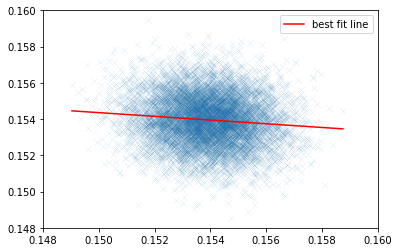

R2:  -0.0037029361570779977
Line Parameters: [-0.00370963  0.1544804 ]


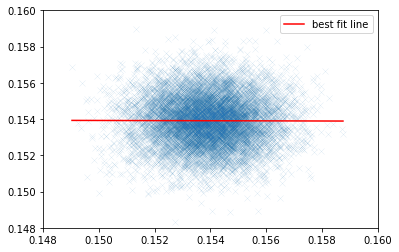

In [24]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

#######SOLUTION###########
plt.scatter(C1C2_bond,C2C3_bond,marker='x',linewidth=0.05)
plt.xlim(0.148,0.160)
plt.ylim(0.148,0.160)

r2 = np.corrcoef(C1C2_bond,C2C3_bond)[0][1]
print("R2: ",r2)

line_fit = np.polyfit(C1C2_bond, C2C3_bond,1)
x = np.linspace(min(C1C2_bond), max(C1C2_bond),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.legend()
plt.show()
plt.clf()

plt.scatter(C1C2_bond,C3C4_bond,marker='x',linewidth=0.05)
plt.xlim(0.148,0.160)
plt.ylim(0.148,0.160)

r2 = np.corrcoef(C1C2_bond,C3C4_bond)[0][1]
print("R2: ",r2)

line_fit = np.polyfit(C1C2_bond, C3C4_bond,1)
x = np.linspace(min(C1C2_bond), max(C1C2_bond),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.legend()
plt.show()


**Homework Question:  Why does one pair of these bonds appear more correlated than the other?**

### Answer: Maybe because one is the coorelation between C1-C2 and C2-C3 bonds, which is a neighbour pair. Another set is C1-C2 and C3-C4, which is less connected thus less correlated.


***Class Activity*** 

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

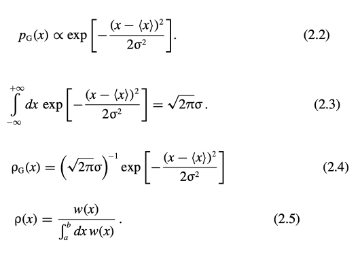
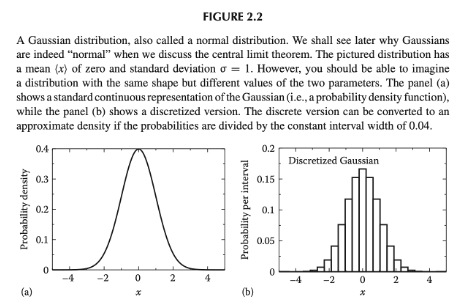

a: 0.18952522750213532 x0: 0.15390735630172425 fit_sigma: -0.001367102645993315


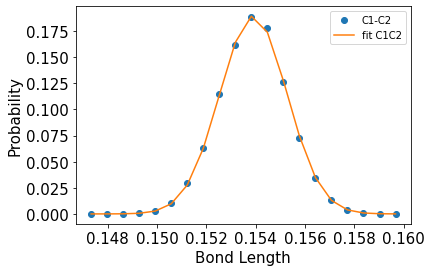

In [25]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

from scipy.optimize import curve_fit

#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:
counts, edges = np.histogram(C1C2_bond, bins = 20, range = [0.147,0.160])
centers = edges[:-1] + np.diff(edges)/2
density = counts/np.sum(counts)
###Now we define a gaussian function that we'll fit to our probability densities

def histogram_bincenters(a,x0,xmax,bins):
    counts, edges = np.histogram(a, bins=bins, range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/np.sum(counts)
    return density, centers

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma] 

C1C2_density, centers = histogram_bincenters(C1C2_bond, 0.147, 0.160, 20)
C1C2_fit, C1C2_fit_params = fit_gauss(centers,C1C2_density)

plt.plot(centers,C1C2_density, 'o', label = 'C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

# plt.clf()
# C2C3_density, centers = histogram_bincenters(C2C3_bond, 0.147, 0.160, 20)
# C2C3_fit, C2C3_fit_params = fit_gauss(centers,C2C3_density)

# plt.plot(centers,C2C3_density, 'o', label = 'C2-C3')
# plt.plot(centers, C2C3_fit, '-', label='fit C2C3')

# plt.legend()
# plt.xlabel('Bond Length', size=15)
# plt.xticks(size=15)
# plt.ylabel('Probability', size=15)
# plt.yticks(size=15)
# plt.show()

***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

a: 0.18952522750213532 x0: 0.15390735630172425 fit_sigma: -0.001367102645993315
a: 0.18748588218592577 x0: 0.153967067633331 fit_sigma: 0.001384485188062303
a: 0.18943251447700818 x0: 0.1539087684150831 fit_sigma: -0.0013666701280474131


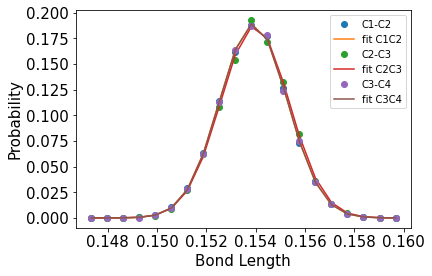

In [26]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####SOLUTION####
C1C2_density, centers = histogram_bincenters(C1C2_bond, 0.147, 0.160, 20)
C1C2_fit, C1C2_fit_params = fit_gauss(centers,C1C2_density)

C2C3_density, centers = histogram_bincenters(C2C3_bond, 0.147, 0.160, 20)
C2C3_fit, C2C3_fit_params = fit_gauss(centers,C2C3_density)

C3C4_density, centers = histogram_bincenters(C3C4_bond, 0.147, 0.160, 20)
C3C4_fit, C3C4_fit_params = fit_gauss(centers,C3C4_density)

plt.plot(centers,C1C2_density, 'o', label = 'C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')
plt.plot(centers,C2C3_density, 'o', label = 'C2-C3')
plt.plot(centers, C2C3_fit, '-', label='fit C2C3')
plt.plot(centers,C3C4_density, 'o', label = 'C3-C4')
plt.plot(centers, C3C4_fit, '-', label='fit C3C4')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

**Homework Problem #2: convert these probability distributions to culmulative distribution functions**

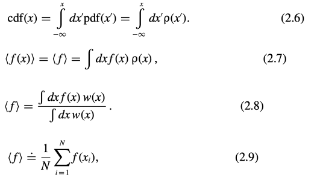

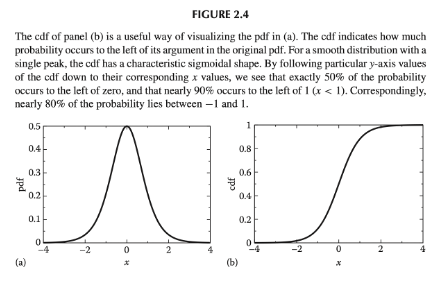

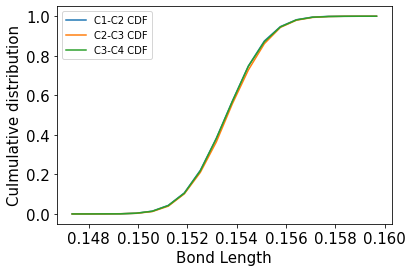

In [27]:
#ADD CODE FOR CDFs HERE#
C1C2_total = []
C2C3_total = []
C3C4_total = []

y = 0
for i in C1C2_density:
    y += i
    C1C2_total.append(y)
y = 0
for i in C2C3_density:
    y += i
    C2C3_total.append(y)
y = 0
for i in C3C4_density:
    y += i
    C3C4_total.append(y)

plt.plot(centers,C1C2_total, '-', label = 'C1-C2 CDF')
plt.plot(centers,C2C3_total, '-', label = 'C2-C3 CDF')
plt.plot(centers,C3C4_total, '-', label = 'C3-C4 CDF')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Culmulative distribution', size=15)
plt.yticks(size=15)
plt.show()

**Homework Problem #3: Lets draw some different some random frames from our trajectory (for example 10,100, and 1000),  calculate the probability distribution functions for 5 of these random samples, and fit  gaussians to these probability distirbution functions***
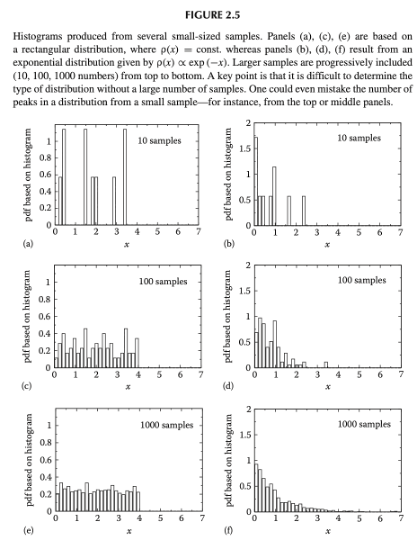

Frame number selected: 10
a: 0.21546189625627055 x0: 0.15317499744392296 fit_sigma: -0.0011046392173464743
a: 0.2275868516391796 x0: 0.15402001585294242 fit_sigma: -0.0011601259918161751
a: 0.4045023172356949 x0: 0.15447322631589855 fit_sigma: -0.0005347951503897416


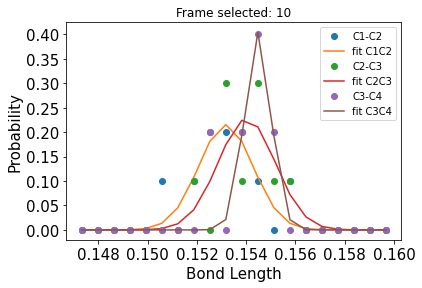

Frame number selected: 50
a: 0.18876619919887272 x0: 0.15404559952372185 fit_sigma: -0.0013967177112733846
a: -5.22882447584058 x0: -6.119289566825105 fit_sigma: -0.024631646929129336
a: 0.18859090119992425 x0: 0.1539455317234053 fit_sigma: -0.0013449870124832483


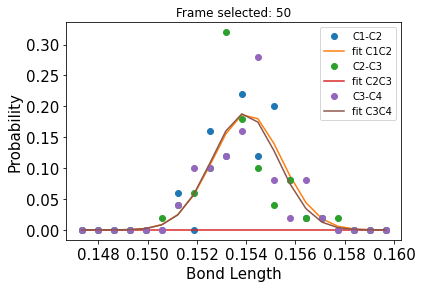

Frame number selected: 100
a: -6.355322508066679 x0: -4.793828630353491 fit_sigma: -0.5163688373637565
a: 0.20879111188970156 x0: 0.15408881052025297 fit_sigma: -0.0012282913966989895
a: 0.20710564448002225 x0: 0.15371433551677097 fit_sigma: -0.001201492106621509


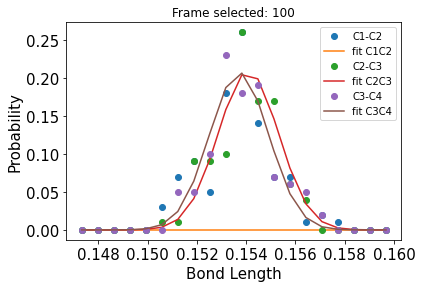

Frame number selected: 1000
a: 0.19078130458181278 x0: 0.15400484967670647 fit_sigma: -0.0013605783052352757
a: 0.18338649026471449 x0: 0.15389899220946496 fit_sigma: 0.001430629317929915
a: 0.19168944970414667 x0: 0.15390598346038 fit_sigma: 0.001349333151543954


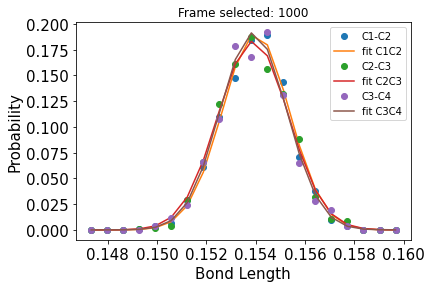

Frame number selected: 5000
a: 0.18757386657576094 x0: 0.1539180047759635 fit_sigma: -0.0013826584665646837
a: 0.1903820059657717 x0: 0.15399449976504884 fit_sigma: -0.0013621819502470385
a: 0.189217487413634 x0: 0.15387829875985795 fit_sigma: -0.0013689452757745934


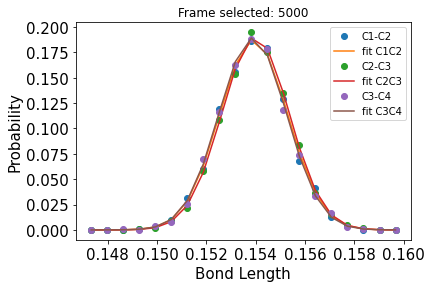

<Figure size 432x288 with 0 Axes>

In [28]:
#ADD CODE FOR Random Samples here#
#Draw 10,100,1000 random samples of a bond angle,

#This function might be helpful:
frame_length = [10,50,100,1000,5000]
for i in frame_length:
    rands=np.random.randint(10000, size=(i))
    print('Frame number selected: ' + str(i))
    C1C2_short = C1C2_bond[rands]
    C2C3_short = C2C3_bond[rands]
    C3C4_short = C3C4_bond[rands]
    C1C2_short_density, centers = histogram_bincenters(C1C2_short, 0.147, 0.160, 20)
    C1C2_short_fit, C1C2_short_fit_params = fit_gauss(centers,C1C2_short_density)

    C2C3_short_density, centers = histogram_bincenters(C2C3_short, 0.147, 0.160, 20)
    C2C3_short_fit, C2C3_short_fit_params = fit_gauss(centers,C2C3_short_density)

    C3C4_short_density, centers = histogram_bincenters(C3C4_short, 0.147, 0.160, 20)
    C3C4_short_fit, C3C4_short_fit_params = fit_gauss(centers,C3C4_short_density)

    plt.plot(centers,C1C2_short_density, 'o', label = 'C1-C2')
    plt.plot(centers, C1C2_short_fit, '-', label='fit C1C2')
    plt.plot(centers,C2C3_short_density, 'o', label = 'C2-C3')
    plt.plot(centers, C2C3_short_fit, '-', label='fit C2C3')
    plt.plot(centers,C3C4_short_density, 'o', label = 'C3-C4')
    plt.plot(centers, C3C4_short_fit, '-', label='fit C3C4')

    plt.legend()
    plt.title('Frame selected: ' + str(i))
    plt.xlabel('Bond Length', size=15)
    plt.xticks(size=15)
    plt.ylabel('Probability', size=15)
    plt.yticks(size=15)
    plt.show()
    plt.clf()

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a good way to visualize the C-C-C-C dihedral angle 

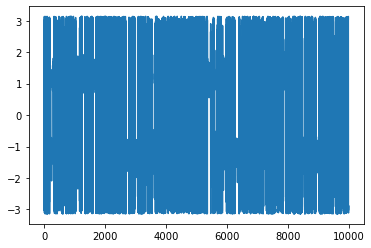

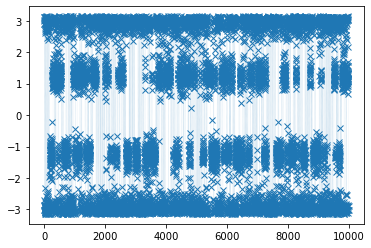

In [29]:
#Lets Compute Some Bond Angles 
Angle1=[0,1,2]
Angle2=[1,2,3]

ang = md.compute_angles(traj,[Angle1,Angle2])
#ang=np.degrees(angle_rad)
ang1 = ang[:,0]
ang2 = ang[:,1]

dihe = md.compute_dihedrals(traj,[[0,1,2,3]])[:,0]
plt.plot(dihe)
plt.show()
plt.clf()
plt.plot(dihe,marker = 'x',linewidth = 0.01)

***Homework Challenge Question:  Can you estimate the lifetime of the higher energy C-C-C-C dihedral states?*****

In [30]:
####Challenge Question Can you estimate the lifetime of the higher energy C-C-C-C dihedral states####

**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

R2:  -0.006316018934690873
Line Parameters: [-1.52154698e-04  1.97188730e+00]


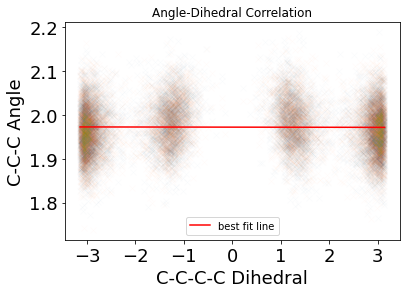

In [31]:
#Are the bond angle and dihedral correlated?
plt.scatter(dihe,ang1,marker = 'x', linewidth = 0.01)
plt.scatter(dihe,ang2,marker = 'x', linewidth = 0.01)

r2 = np.corrcoef(dihe,ang1)[0,1]
print("R2: ",r2)

line_fit = np.polyfit(dihe, ang1,1)
x = np.linspace(min(dihe), max(dihe),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.legend()
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('C-C-C-C Dihedral', size=18)
plt.ylabel('C-C-C Angle', size=18)
plt.title('Angle-Dihedral Correlation')
plt.show()

#plt.scatter(ang1[1:-1:10],ang2[1:-1:10])
#r=np.corrcoef(ang1, ang2)
#print("Angle Correlation r^2:",r[0,1])


**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

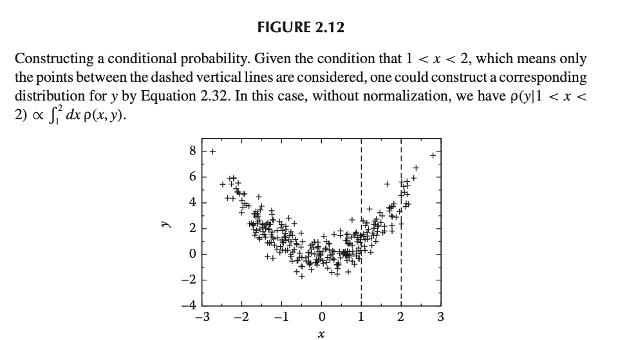

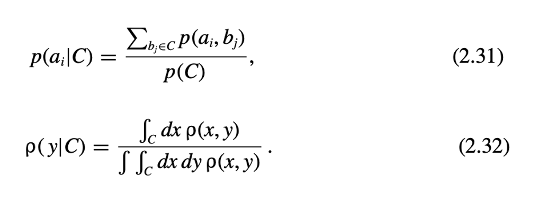

/home/daisy/anaconda3/envs/openmm/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


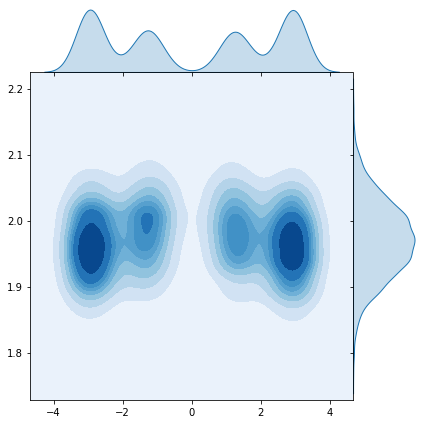

/home/daisy/anaconda3/envs/openmm/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 432x288 with 0 Axes>

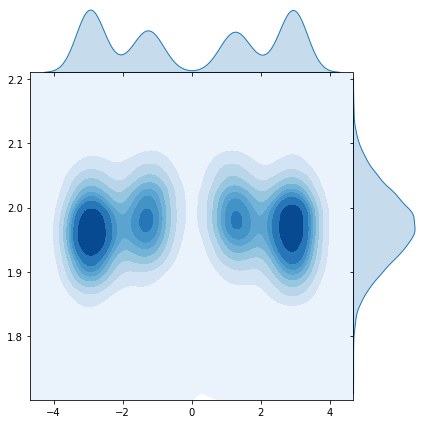

In [32]:
#Homework problem 3##
# 2d Histagram of C1-C2-C3-C4 dihedral and C1-C2-C3 angle
sns.jointplot(dihe,ang1,kind = 'kde', space=0, fill=True, thresh=0, cmap='Blues')
plt.show()

plt.clf()
# 2d Histagram of C1-C2-C3-C4 dihedral and C2-C3-C4 angle
sns.jointplot(dihe,ang2,kind = 'kde', space=0, fill=True, thresh=0, cmap='Blues')
plt.show()

In [33]:
def condition_1d(up, down, array):
    # new = array[(array > down) and (array < up)]
    count = 0
    for i in range(len(array)):
        if array[i] > down and array[i] < up:
            count+=1
    return count/len(array)

def condition_2d(up1, down1, up2, down2, array1, array2):
    count = 0
    array = np.vstack((array1, array2)).T
    for i in range(len(array)):
        if array[i][0] > down1 and array[i][0] < up1:
            if array[i][1] > down2 and array[i][1] < up2:
                count+=1
    return count/len(array)

# Conditions: -2 < Dihe < 0, and 1.8 < ang1(ang2) < 2.0
# Event A: 1.8 < ang1(ang2) < 2.0, event B: -2 < Dihe < 0
# Calculating P(A|B)
condition1 = condition_2d(0, -2, 2.0, 1.8,dihe,ang1)
print(condition1)
condition2 = condition_2d(0, -2, 2.0, 1.8,dihe,ang2)
print(condition2)
p1 = condition1/condition_1d(0,-2,dihe)
p2 = condition2/condition_1d(0,-2,dihe)
print('p1 = ',p1,', and p2 = ',p2)

0.1248
0.1291
p1 =  0.5886792452830188 , and p2 =  0.6089622641509433


**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

[0.00000000e+00 2.00020002e+00 4.00040004e+00 ... 1.99959996e+04
 1.99979998e+04 2.00000000e+04]


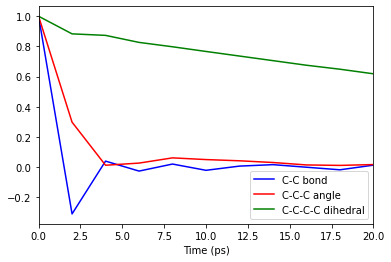

In [34]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2_bond,lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(dihe),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.xlabel('Time (ps)')
plt.xlim(0,20)
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

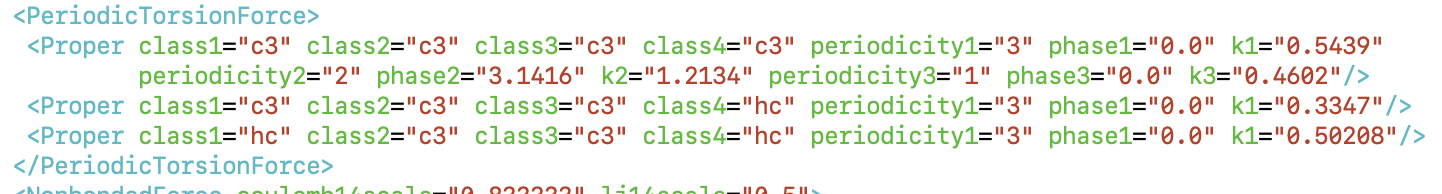

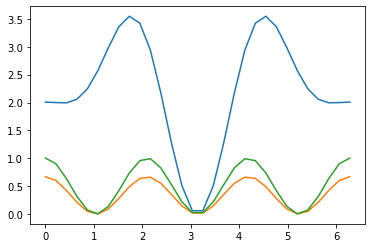

In [35]:
#Plot The Torsion Force Field Terms
import math
#First Lets make a linespace from -pi to pi
rad_ang = np.linspace(0, 2 * math.pi, 30)

##Lets right a function that takes paramters from the xml and writes the force field term
#Plot The Torsion Force Field Terms

#First Lets make a linespace from -pi to pi
rad_ang = np.linspace(0, 2 * math.pi, 30)

##Lets right a function that takes paramters from the xml and writes the force field term


def calc_torsion_energy(angle, k1, period, phase):
    e = k1 * (1 + np.cos(period * angle - phase))
    return e


def CCCC_torsionE(angle):
    e1 = calc_torsion_energy(angle, 0.4602, 1, 0)
    e2 = calc_torsion_energy(angle, 1.2134, 2, 3.1416)
    e3 = calc_torsion_energy(angle, 0.5439, 3, 0)
    return e1 + e2 + e3


def CCCH_torsionE(angle):
    e1 = calc_torsion_energy(angle, 0.3347, 3, 0)
    return e1


def HCCH_torsionE(angle):
    e1 = calc_torsion_energy(angle, 0.50208, 3, 0)
    return e1


CCCC_e = CCCC_torsionE(rad_ang)
CCCH_e = CCCH_torsionE(rad_ang)
HCCH_e = HCCH_torsionE(rad_ang)

plt.plot(rad_ang, CCCC_e)
plt.plot(rad_ang, CCCH_e)
plt.plot(rad_ang, HCCH_e)


In [36]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,LIG,0,
1,2,C2,C,1,LIG,0,
2,3,C3,C,1,LIG,0,
3,4,C4,C,1,LIG,0,
4,5,H11,H,1,LIG,0,
5,6,H12,H,1,LIG,0,
6,7,H13,H,1,LIG,0,
7,8,H21,H,1,LIG,0,
8,9,H22,H,1,LIG,0,
9,10,H31,H,1,LIG,0,


 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [37]:
#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-3-2-(10,9)-1-(8,7)-0-(6,5,4)

CCCC_index = [0,1,2,3]
HCCH_index = [[13,3,2,10],[13,3,2,9],[12,3,2,10],[12,3,2,9],[11,3,2,10],[11,3,2,9],[10,2,1,8],[10,2,1,7],[9,2,1,8],[9,2,1,7],[8,1,0,6],[8,1,0,5],[8,1,0,4],[7,1,0,6],[7,1,0,5],[7,1,0,4]]
CCCH_index = [[3,2,1,8],[3,2,1,7],[2,1,0,6],[2,1,0,5],[2,1,0,4],[0,1,2,9],[0,1,2,10],[1,2,3,11],[1,2,3,12],[1,2,3,13]]

CCCC_torsion = md.compute_dihedrals(traj,[CCCC_index])
HCCH_torsion = md.compute_dihedrals(traj,HCCH_index)
CCCH_torsion = md.compute_dihedrals(traj,CCCH_index)

**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  Why isn't it always the same?

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

R2:  0.6960994401765498
Line Parameters: [0.69236174 0.02225603]


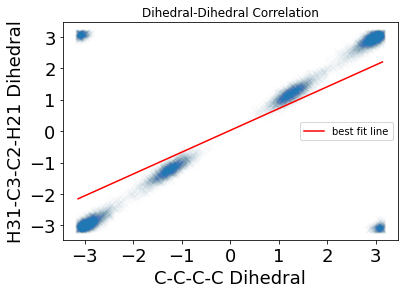

R2:  0.02801601750707745
Line Parameters: [0.02233234 0.03440566]


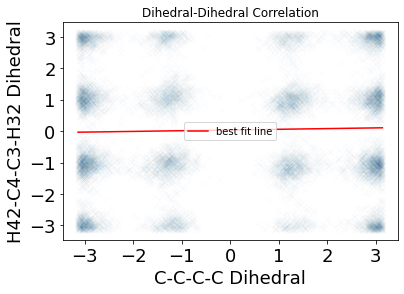

<Figure size 432x288 with 0 Axes>

In [38]:
####Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
tor1 = [0,1,2,3]
tor2 = [9,2,1,7]
tor3 = [12,3,2,10]
dihe_coor = md.compute_dihedrals(traj,[tor1,tor2,tor3])
dihe1 = dihe_coor[:,0]
dihe2 = dihe_coor[:,1]
dihe3 = dihe_coor[:,2]
#Consider CCCC vs. [8,7,4,5](not the number in my pdb)
# [H31, C3, C2, H21] = [9, 2, 1, 7]
plt.scatter(dihe1, dihe2,marker = 'x', linewidth = 0.01)
r2 = np.corrcoef(dihe1,dihe2)[0,1]
print("R2: ",r2)

line_fit = np.polyfit(dihe1, dihe2,1)
x = np.linspace(min(dihe1), max(dihe1),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.legend()
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('C-C-C-C Dihedral', size=18)
plt.ylabel('H31-C3-C2-H21 Dihedral', size=18)
plt.title('Dihedral-Dihedral Correlation')
plt.show()
plt.clf()
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9](not the number in my pdb)
# [H42, C4, C3, H32] = [12, 2, 1, 10]
plt.scatter(dihe1, dihe3,marker = 'x', linewidth = 0.01)
r2 = np.corrcoef(dihe1,dihe3)[0,1]
print("R2: ",r2)

line_fit = np.polyfit(dihe1, dihe3,1)
x = np.linspace(min(dihe1), max(dihe1),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.legend()
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('C-C-C-C Dihedral', size=18)
plt.ylabel('H42-C4-C3-H32 Dihedral', size=18)
plt.title('Dihedral-Dihedral Correlation')
plt.show()
plt.clf()

Answer: In the first case, the dihedral HCCH shares the same C2-C3 as CCCC. Since all the carbons are sp3 carbons, H31 could take the same place as C4, and H21 could take the same place as C1. So H31-C3-C2-H21 can be highly correlated to C4-C3-C2-C1 dihedral. And in the second case, there's no obvious relationship between CCCC and H42-C4-C3-H32, so they are not correlated.

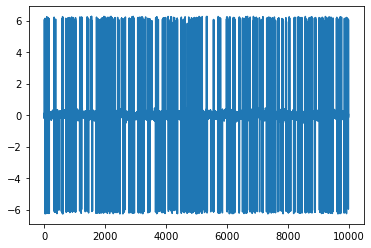

In [39]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
#plt.scatter(CCCC_torsion,HCCH_torsions[:,1],marker='x',linewidth=0.04)
diff=dihe1-dihe2
plt.plot(diff)


Answer: I'm using the previous correlated two dihedrals: CCCC and H31-C3-C2-H21 and I believe since they are correlated, they would have a systematic offset.

Text(0.5, 1.0, 'Total torsion force field energy per frame')

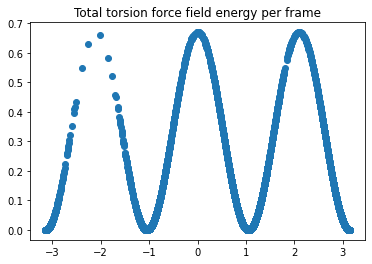

In [40]:
#COMPUTE THE TOTAL TORSION FORCE FIELD ENERGY PER FRAME
CCCH_E = CCCH_torsionE(CCCH_torsion)
plt.scatter(CCCH_torsion[:,0],CCCH_E[:,0])
plt.title('Total torsion force field energy per frame')


Text(0.5, 0, 'Frame')

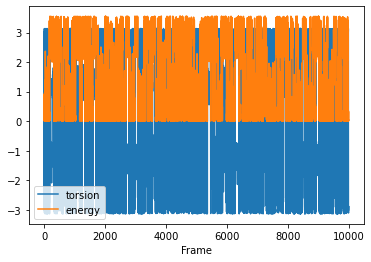

In [41]:
#Compare the time course of CCCC torsion with its energy 
#Interpret what you are seeing in terms of conformations and energies

CCCC_E = CCCC_torsionE(dihe)
plt.plot(dihe, label = 'torsion')
plt.plot(CCCC_E, label = 'energy')
plt.legend()
plt.xlabel('Frame')


For the conformations with a large torsion of CCCC (-pi or pi) and the conformations with torsion angle of +-1, the energy will be larger. And the other two distributions (+-2 and 0), the conformational energy will be smaller. Overall the shape is symetric and the energy is opposite of torsion distribution. 

Plot The Total Torsion Energy As a Function of the C-C-C-C Dihedral Angle - Compare your plot Energetic Torsion Barriers from Cramer.  How Can you explain the Difference?

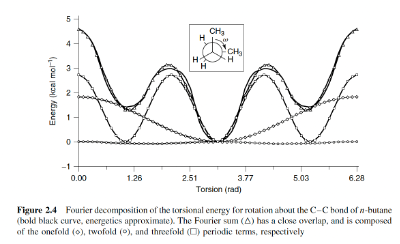

Text(0, 0.5, 'Energy')

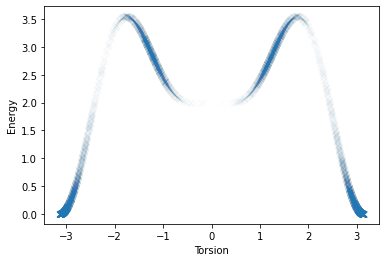

In [42]:
#Solution
plt.scatter(dihe, CCCC_E, marker = 'x', linewidth = 0.01)
plt.xlabel('Torsion')
plt.ylabel("Energy")

Answer: The plot I have well-matched Cramer's plot in the part where -2 < rad < 2, but it doesn't match well when rad = pi or -pi. I'm pretty confused about the differences here. I can't figure out where I went wrong for this.

***Homework Problem #6: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

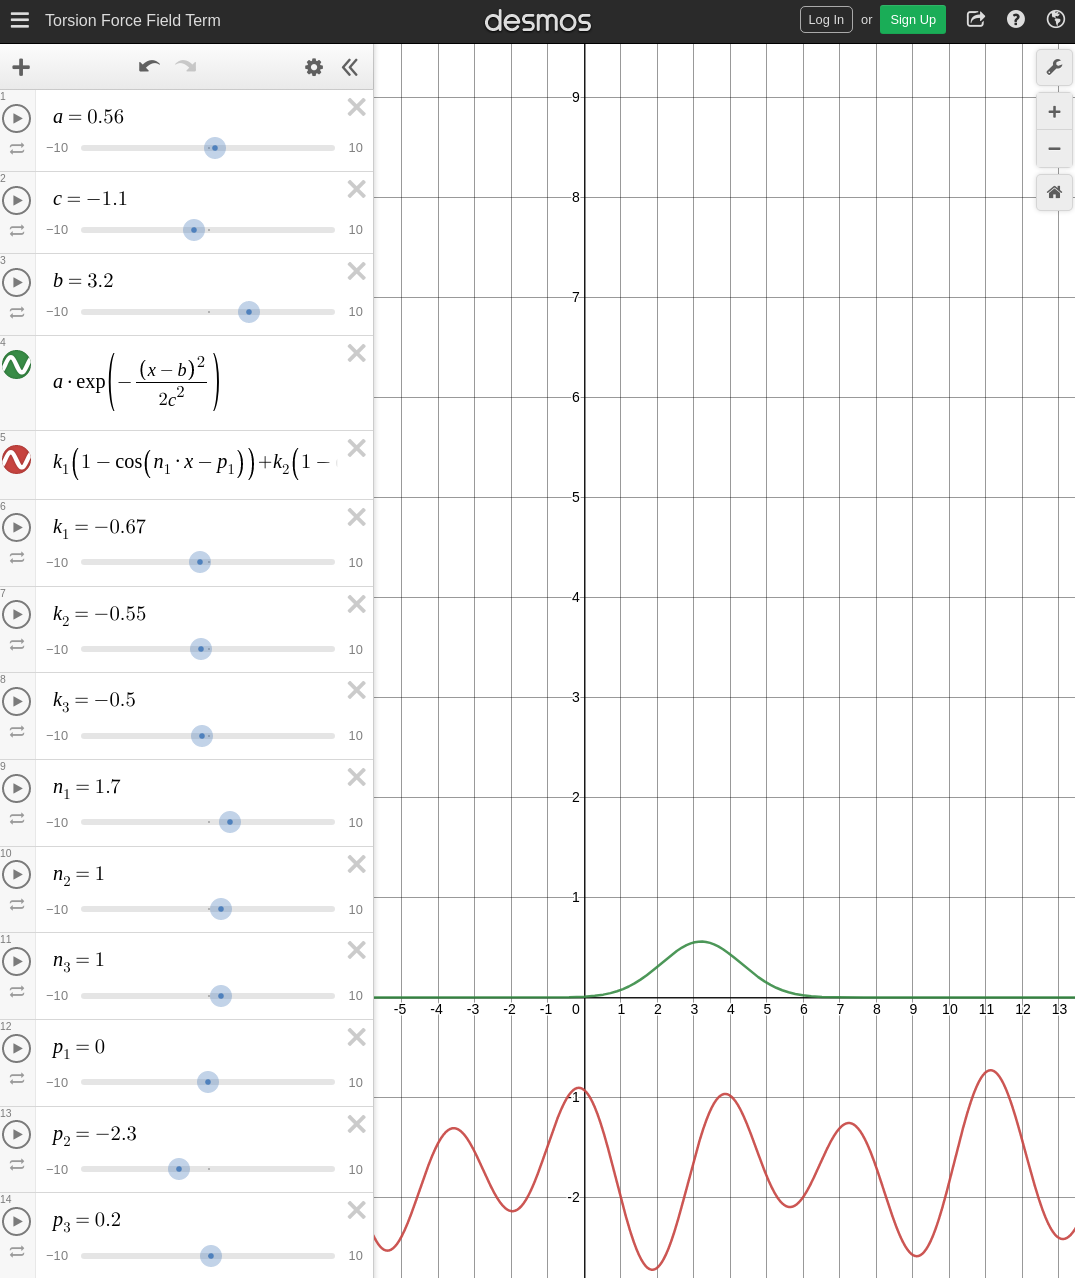

In [43]:
###SOLUTION#####
from IPython.display import Image
Image(filename='phase.png')

***Homework Problem #7: Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [46]:
#RUN NEW MD SIMULATION HERE#
force_field='/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/butane.gaff2.new.xml'

if not os.path.exists(workDir):
    os.makedirs(workDir)
    
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/butane.pdb
/home/daisy/Documents/Chem_course/Chem101.6/Assignment1/butane.gaff2.new.xml


In [47]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 15.421035200902127 kJ/mol
Potential energy after minimization is 7.26959090468182 kJ/mol


In [48]:
print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 250, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(298.0*unit.kelvin)
simulation.step(5000)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,27.25430417522759,209.95584001246704
500,36.45285173831128,339.52156997458445
750,47.28776786600675,326.0293176269243
1000,47.31732435657752,216.1732032438078
1250,43.572617012611765,344.50967966631566
1500,47.937119400065384,228.85626493181996
1750,41.2331789708154,316.38469404851134
2000,52.01616651798104,261.4011576070655
2250,40.20016451203865,273.3317957982023
2500,56.39850566486035,270.38912125937986
2750,71.05874750820043,511.3426605017232
3000,38.59824050785333,368.6975767522015
3250,40.08594484541679,246.89640831469913
3500,38.09963924057245,370.4183923926233
3750,47.929570308533314,511.95588380076276
4000,43.36972753586062,367.70593545361135
4250,65.3681746694127,227.32210890722087
4500,51.790909396293145,268.0572687571791
4750,51.898192342185354,368.20918572260905
5000,33.899900983794474,211.16104518620125


In [50]:
import time as time
print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.new.dcd', 100))

# run the simulation for 1.0x10^7*2 steps - 20*2 = 40 ns
simulation.step(20000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,32.57639466478223,337.32920499040523,0
500000,999.9999999901769,33.36730511917335,204.1963871414747,1.65e+04
750000,1499.9999999783536,49.705847932734294,441.3143536293337,1.64e+04
1000000,1999.9999999665301,40.86449332419264,222.57201564670805,1.61e+04
1250000,2499.9999999547067,28.393052026661618,217.5742475865036,1.61e+04
1500000,2999.9999999428833,51.843471868495314,240.1034347480018,1.62e+04
1750000,3499.99999993106,33.18762058109207,403.0879539161116,1.63e+04
2000000,3999.9999999192364,31.09497119534065,264.14579439240424,1.64e+04
2250000,4499.9999999992715,38.711153323939214,236.32540057993512,1.64e+04
2500000,5000.000000101135,37.29236736018321,352.0216679810002,1.65e+04
2750000,5500.000000202998,55.0010987552996,263.61783407059403,1.65e+04
3000000,6000.000000304862,58.1419850878101,354.6786428469937,1.65e+04
3250000,6500.000000406725,53.43094797391

In [52]:
traj_new = md.load(datadir+'butane_sim.new.dcd', top=initial_pdb)
traj_new

<mdtraj.Trajectory with 200000 frames, 14 atoms, 1 residues, without unitcells at 0x7ff21459fa90>

In [57]:
def CCCC_torsionE(angle):
    e1 = calc_torsion_energy(angle, 0.50208, 1, 0)
    e2 = calc_torsion_energy(angle, 1.2134, 2, -2.3)
    e3 = calc_torsion_energy(angle, 0.5439, 3, 0.2)
    return e1 + e2 + e3

Text(0.5, 0, 'Frame')

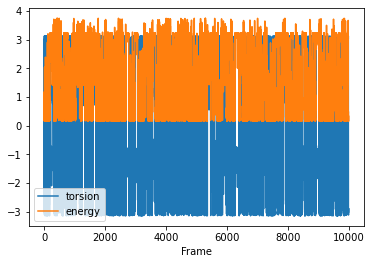

In [58]:
re_dihe = md.compute_dihedrals(traj,[CCCC_index])
re_CCCC_E = CCCC_torsionE(re_dihe)
plt.plot(re_dihe, label = 'torsion')
plt.plot(re_CCCC_E, label = 'energy')
plt.legend()
plt.xlabel('Frame')


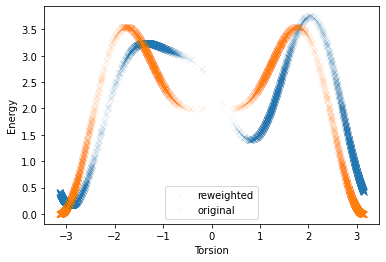

In [60]:
plt.scatter(re_dihe, re_CCCC_E, marker = 'x', linewidth = 0.04,label = 'reweighted')
plt.scatter(dihe, CCCC_E, marker = 'x', linewidth = 0.04,label = 'original')
plt.xlabel('Torsion')
plt.ylabel("Energy")
plt.legend()

**Homework Problem #8:  Calculate LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

**Challenge Problem:  Atempt to calculate all LJ interactions for a frame and all frames.  What does lj14scale mean?**


**Challenge Problem #2:  Attempt to calculate all Coulumb interactions for a frame and all frames**

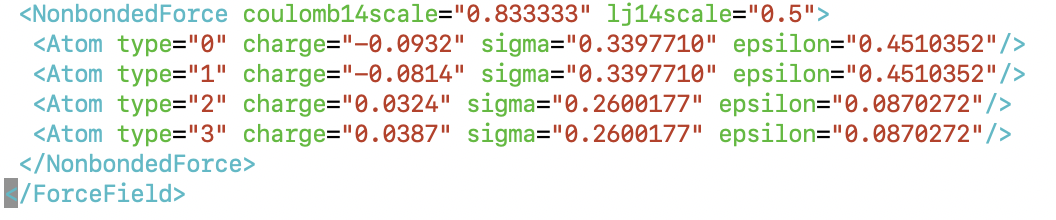




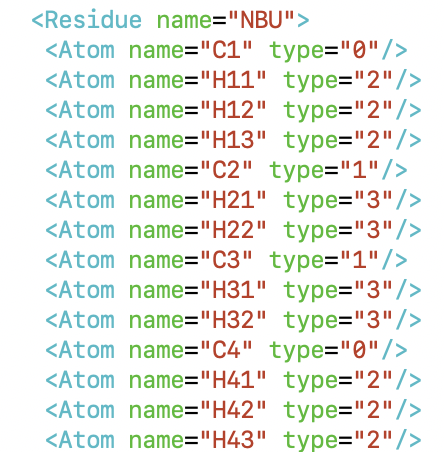

In [61]:
#Calculate LJ and Couloumb Potentionals Here
sig1 = 0.3397710
ep1 = 0.4510352
sig2 = 0.2600177
ep2 = 0.0870272
c1 = -0.0932
c2 = -0.0814
c3 = 0.0324
c4 = 0.0387


/home/daisy/anaconda3/envs/openmm/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/daisy/anaconda3/envs/openmm/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


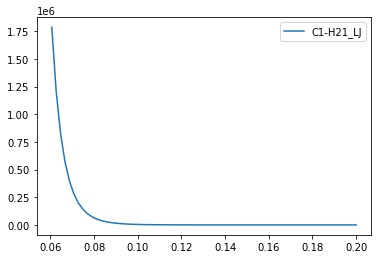

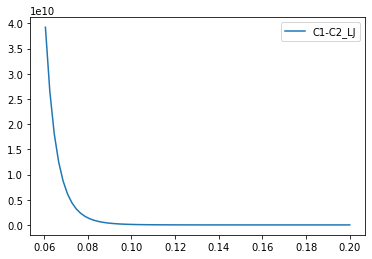

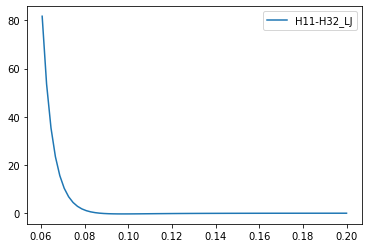

<Figure size 432x288 with 0 Axes>

In [78]:
# Type 1: C1-H21 (0-3), type2 = C1-C2 (0-1), type3 = H11-H32 (2-3)
r = np.linspace(0.,0.2,100)
def LJ(sig,ep,r):
    A = 4*sig*(ep**12)
    B = 4*sig*(ep**6)
    return A/(r**12)-B/(r**6)

def combine_sig(sig1,sig2):
    return 0.5*sig1 + 0.5*sig2

def combine_ep(ep1,ep2):
    return (ep1*ep2)**0.5

C1H21_LJ = LJ(combine_sig(sig1,sig2),combine_ep(ep1,ep2),r)
C1C2_LJ = LJ(combine_sig(sig1,sig1),combine_ep(ep1,ep1),r)
H11H32_LJ = LJ(combine_sig(sig2,sig1),combine_ep(ep2,ep2),r)

plt.plot(r[30:],C1H21_LJ[30:], label = 'C1-H21_LJ')
plt.legend()
plt.show()
plt.clf()
plt.plot(r[30:],C1C2_LJ[30:], label = 'C1-C2_LJ')
plt.legend()
plt.show()
plt.clf()
plt.plot(r[30:],H11H32_LJ[30:], label = 'H11-H32_LJ')
plt.legend()
plt.show()
plt.clf()

/home/daisy/anaconda3/envs/openmm/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


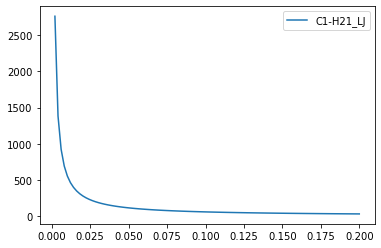

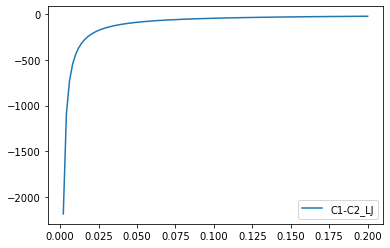

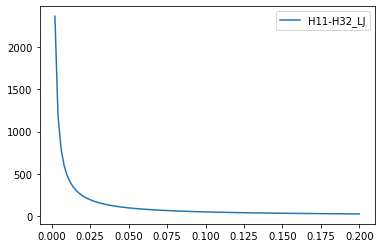

<Figure size 432x288 with 0 Axes>

In [81]:
# Coulumbic potential
# Atom paird: 0-1, 1-2, 2-3
def coulumb(q1,q2,r,ep):
    return (332*q1*q2)/(ep*r)

co1 = coulumb(c1,c2,r,combine_ep(ep1,ep1))
co2 = coulumb(c2,c3,r,combine_ep(ep1,ep2))
co3 = coulumb(c3,c4,r,combine_ep(ep2,ep2))

plt.plot(r,co1, label = 'C1-H21_LJ')
plt.legend()
plt.show()
plt.clf()
plt.plot(r,co2, label = 'C1-C2_LJ')
plt.legend()
plt.show()
plt.clf()
plt.plot(r,co3, label = 'H11-H32_LJ')
plt.legend()
plt.show()
plt.clf()

***Having fun with small molecule simulations?  Why not simulate a new molecule that you think might be interesting***

You can install a conda package that lets you generate a molecular structure and force field from a SMILES string:

conda install --yes -c conda-forge openmmforcefields

conda install -c conda-forge openff-toolkit    

And you can find the documentation to generate a structure and force field for a compound here
https://github.com/openmm/openmmforcefields

You can draw a structure here and convert it to a SMILES string and download and sdf file to build an openMM system here: 

http://www.cheminfo.org/Chemistry/Cheminformatics/FormatConverter/index.html

